In [2]:
import ee
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import savgol_filter

In [3]:
ee.Initialize()

In [4]:
point = ee.Geometry.Point([116.966795, -32.506067])



# MODIS GPP

In [5]:
start_date = '2021-01-01'
end_date = '2024-12-31'


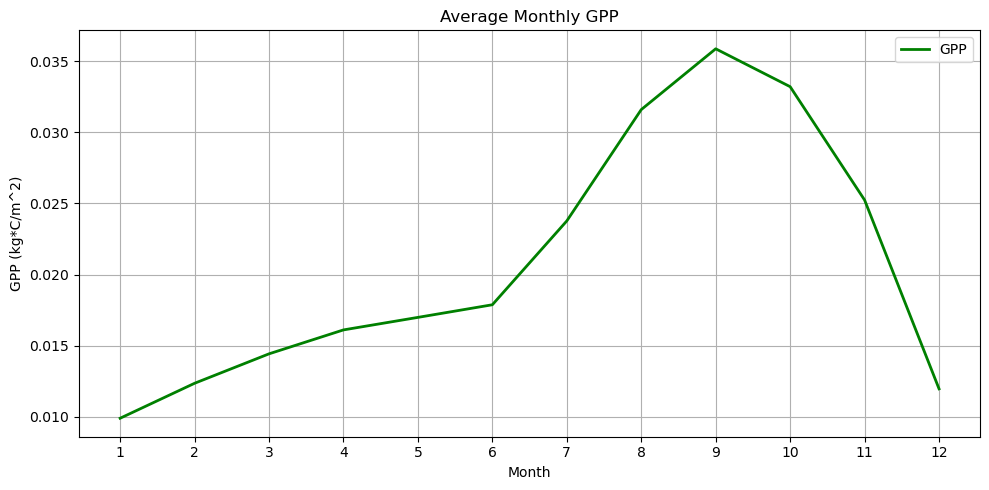

In [11]:
# Load MODIS GPP collection
collection = (
    ee.ImageCollection('MODIS/061/MYD17A2H')
    .filterBounds(point)
    .filterDate(start_date, end_date)
    .select('Gpp')
)

# Function to extract GPP and date from each image
def extract_gpp(image):
    gpp_value = image.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=point,
        scale=500
    ).get('Gpp')
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'GPP': gpp_value, 'date': date})

# Map extraction function over the collection
features = collection.map(extract_gpp)

# Get features info from server
feature_list = features.getInfo().get('features', [])

# Extract data into a Python list
data = []
for f in feature_list:
    props = f.get('properties', {})
    if 'date' in props and 'GPP' in props and props['GPP'] is not None:
        scaled_gpp = props['GPP'] * 0.0001
        data.append({
            'date': props['date'],
            'GPP': scaled_gpp
        })

# Create DataFrame
df = pd.DataFrame(data)

if df.empty:
    print("No GPP data found for the given point and date range.")
else:
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month

    # Compute monthly mean GPP per year/month
    monthly_mean_gpp = df.groupby(['year', 'month'])['GPP'].mean().reset_index()

    # Compute multi-year mean GPP for each month (Jan to Dec)
    multi_year_monthly_mean = monthly_mean_gpp.groupby('month')['GPP'].mean().reset_index()

    # Apply Savitzky-Golay filter to smooth the monthly means
    # window_length must be odd and <= length of data (here length=12)
    window_length = 7  # You can adjust this (must be odd)
    polyorder = 2

    multi_year_monthly_mean['GPP_smooth'] = savgol_filter(
        multi_year_monthly_mean['GPP'], window_length=window_length, polyorder=polyorder)

    # Plot original and smoothed monthly mean GPP
    plt.figure(figsize=(10, 5))
    #plt.plot(multi_year_monthly_mean['month'], multi_year_monthly_mean['GPP'], 
     #        marker='o', linestyle='-', label='Original')
    plt.plot(multi_year_monthly_mean['month'], multi_year_monthly_mean['GPP_smooth'], 
             color='green', linewidth=2, label='GPP')
    plt.xticks(range(1, 13))
    plt.title('Average Monthly GPP')
    plt.xlabel('Month')
    plt.ylabel('GPP (kg*C/m^2)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('modis_gpp.png', dpi=300)
    plt.show()


# MODIS NDVI

In [54]:
# Date range 
start_date = '2016-01-01'
end_date = '2024-12-31'

# Load MODIS MYD09A1 collection (8-day, Aqua)
collection = (
    ee.ImageCollection('MODIS/061/MYD09A1')
    .filterBounds(point)
    .filterDate(start_date, end_date)
    .select(['sur_refl_b01', 'sur_refl_b02'])  # Red and NIR
)

# Compute NDVI
def add_ndvi(image):
    red = image.select('sur_refl_b01').multiply(0.0001)
    nir = image.select('sur_refl_b02').multiply(0.0001)
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
    return image.addBands(ndvi)

collection_ndvi = collection.map(add_ndvi).select('NDVI')

# Extract NDVI and date
def extract_ndvi(image):
    ndvi_value = image.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=point,
        scale=500  # MODIS resolution
    ).get('NDVI')
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'NDVI': ndvi_value, 'date': date})

features = collection_ndvi.map(extract_ndvi)
feature_list = features.getInfo().get('features', [])

# Build DataFrame
data = []
for f in feature_list:
    props = f.get('properties', {})
    if 'date' in props and 'NDVI' in props and props['NDVI'] is not None:
        data.append({'date': props['date'], 'NDVI': props['NDVI']})

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

# Smooth NDVI using Savitzky-Golay filter
ndvi_values = df['NDVI'].values
window_length = 7
if window_length > len(ndvi_values):
    window_length = len(ndvi_values) if len(ndvi_values) % 2 == 1 else len(ndvi_values) - 1
polyorder = 2
df['NDVI_smooth'] = savgol_filter(ndvi_values, window_length, polyorder)

print(df)


          date      NDVI  NDVI_smooth
0   2016-01-01  0.205566     0.199905
1   2016-01-09  0.207555     0.220389
2   2016-01-17  0.247462     0.235936
3   2016-01-25  0.235776     0.246545
4   2016-02-02  0.258790     0.252770
..         ...       ...          ...
406 2024-11-24  0.277077     0.254450
407 2024-12-02  0.213623     0.238354
408 2024-12-10  0.218594     0.226785
409 2024-12-18  0.233019     0.221160
410 2024-12-26  0.220382     0.221479

[411 rows x 3 columns]


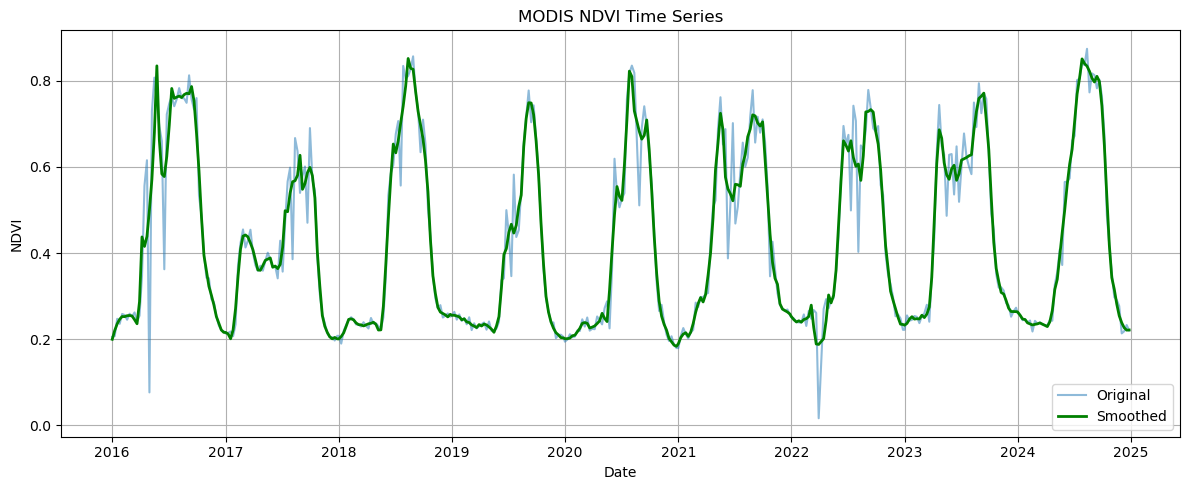

In [55]:
plt.figure(figsize=(12, 5))

# Plot original i35 values
plt.plot(df['date'], df['NDVI'], label='Original', linestyle='-', alpha=0.5)

# Plot smoothed i35 values
plt.plot(df['date'], df['NDVI_smooth'], label='Smoothed', color='green', linewidth=2)

plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('MODIS NDVI Time Series')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('modis_NDVI_time_series.png', dpi=300)
plt.show()

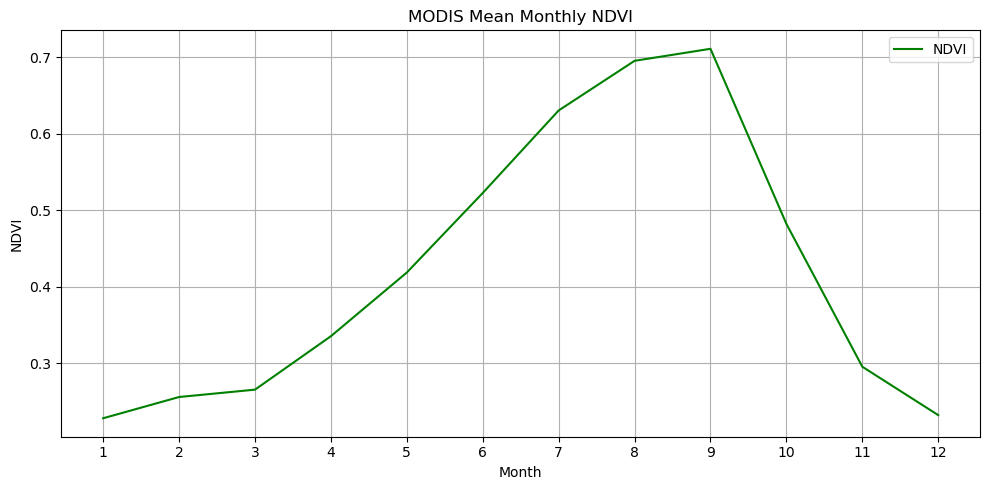

In [56]:
# Add a 'month' column
df['month'] = df['date'].dt.month

# Calculate monthly average i35 across all years
monthly_mean_NDVI = df.groupby('month')['NDVI'].mean().reset_index()

# Apply SG filter
window_length = 7  # should be odd and ≤ number of months (12)
if window_length > len(monthly_mean_NDVI):
    window_length = len(monthly_mean_NDVI) if len(monthly_mean_NDVI) % 2 == 1 else len(monthly_mean_NDVI) - 1
polyorder = 2
monthly_mean_NDVI['NDVI_smooth'] = savgol_filter(monthly_mean_NDVI['NDVI'], window_length, polyorder)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_mean_NDVI['month'], monthly_mean_NDVI['NDVI'], 
         label='NDVI', color = 'green')
#plt.plot(monthly_mean_NDVI['month'], monthly_mean_NDVI['NDVI_smooth'], 
 #        label='Smoothed NDVI (SG Filter)', marker='s', linestyle='--', color='red')

plt.xticks(range(1, 13))
plt.xlabel('Month')
plt.ylabel('NDVI')
plt.title('MODIS Mean Monthly NDVI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('modis_NDVI.png', dpi=300)
plt.show()

# MODIS i35

In [23]:
start_date = '2016-01-01'
end_date = '2024-12-31'

# Load MODIS surface reflectance collection (MYD09A1)
collection = (
    ee.ImageCollection('MODIS/061/MYD09A1')
    .filterBounds(point)
    .filterDate(start_date, end_date)
    .select(['sur_refl_b01', 'sur_refl_b06'])  # Red and SWIR bands
)

# Function to calculate i35 index
def add_i35(image):
    red = image.select('sur_refl_b01').multiply(0.0001)
    swir = image.select('sur_refl_b06').multiply(0.0001)
    i35 = red.add(swir).divide(2).rename('i35')
    return image.addBands(i35)

# Map i35 calculation
collection_i35 = collection.map(add_i35).select('i35')

# Function to extract i35 value and date
def extract_i35(image):
    i35_value = image.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=point,
        scale=500  # MODIS resolution
    ).get('i35')
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'i35': i35_value, 'date': date})

# Extract features
features = collection_i35.map(extract_i35)
feature_list = features.getInfo().get('features', [])

# Convert to DataFrame
data = []
for f in feature_list:
    props = f.get('properties', {})
    if 'date' in props and 'i35' in props and props['i35'] is not None:
        data.append({
            'date': props['date'],
            'i35': props['i35']
        })

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

# Apply Savitzky-Golay filter
i35_values = df['i35'].values
window_length = 7
if window_length > len(i35_values):
    window_length = len(i35_values) if len(i35_values) % 2 == 1 else len(i35_values) - 1
polyorder = 2
i35_smooth = savgol_filter(i35_values, window_length, polyorder)

# Add smoothed values to DataFrame
df['i35_smooth'] = i35_smooth

print(df)


          date      i35  i35_smooth
0   2016-01-01  0.32950    0.314065
1   2016-01-25  0.32450    0.336439
2   2016-02-02  0.30995    0.335721
3   2016-02-26  0.30310    0.311912
4   2016-04-06  0.33395    0.254464
..         ...      ...         ...
172 2024-07-27  0.12475    0.115619
173 2024-09-05  0.11155    0.157376
174 2024-10-23  0.22130    0.206875
175 2024-12-10  0.35065    0.279532
176 2024-12-26  0.33175    0.375348

[177 rows x 3 columns]


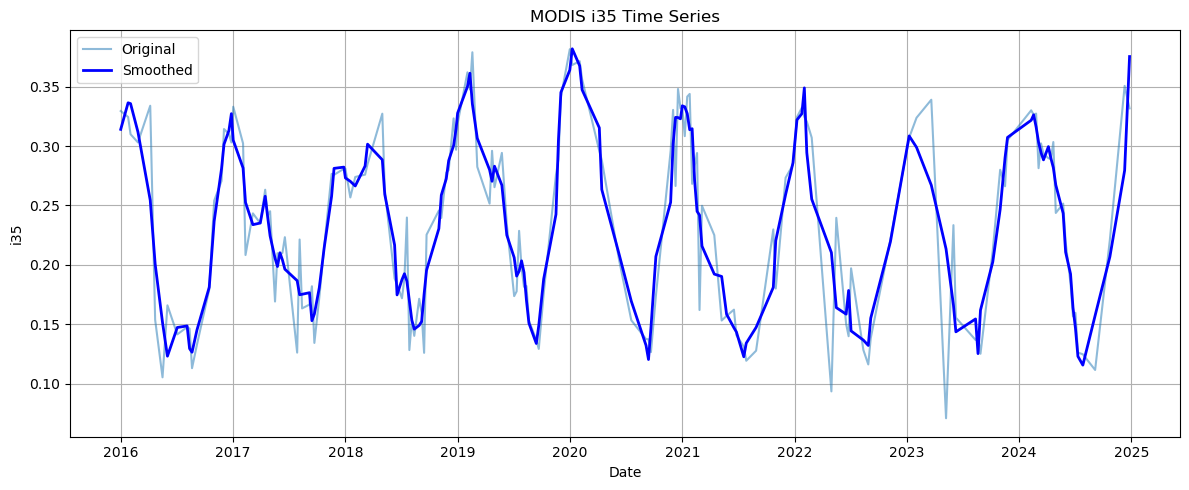

In [27]:
plt.figure(figsize=(12, 5))

# Plot original i35 values
plt.plot(df['date'], df['i35'], label='Original', linestyle='-', alpha=0.5)

# Plot smoothed i35 values
plt.plot(df['date'], df['i35_smooth'], label='Smoothed', color='blue', linewidth=2)

plt.xlabel('Date')
plt.ylabel('i35')
plt.title('MODIS i35 Time Series')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('modis_i35_time_series.png', dpi=300)
plt.show()

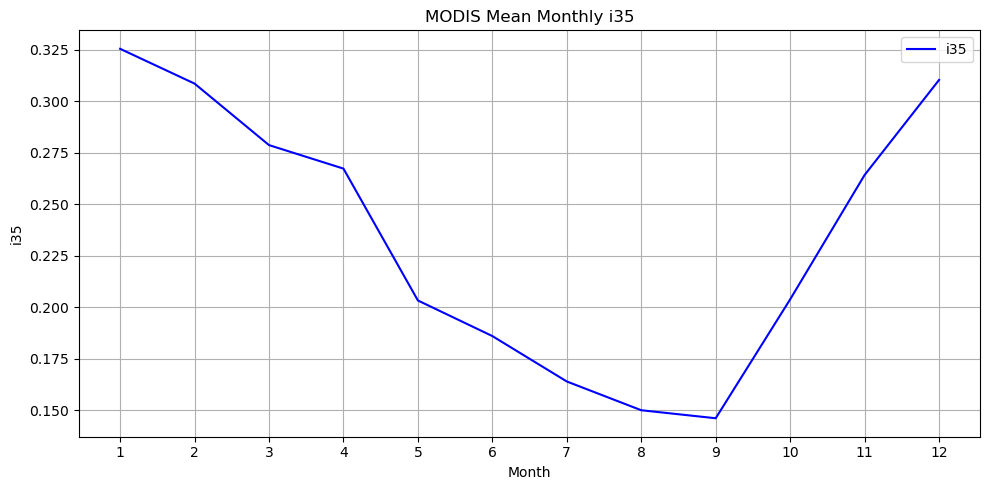

In [31]:
# Add a 'month' column
df['month'] = df['date'].dt.month

# Calculate monthly average i35 across all years
monthly_mean_i35 = df.groupby('month')['i35'].mean().reset_index()

# Apply SG filter
window_length = 7  # should be odd and ≤ number of months (12)
if window_length > len(monthly_mean_i35):
    window_length = len(monthly_mean_i35) if len(monthly_mean_i35) % 2 == 1 else len(monthly_mean_i35) - 1
polyorder = 2
monthly_mean_i35['i35_smooth'] = savgol_filter(monthly_mean_i35['i35'], window_length, polyorder)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_mean_i35['month'], monthly_mean_i35['i35'], 
         label='i35', color = 'blue')
#plt.plot(monthly_mean_i35['month'], monthly_mean_i35['i35_smooth'], 
 #        label='Smoothed i35 (SG Filter)', marker='s', linestyle='--', color='red')

plt.xticks(range(1, 13))
plt.xlabel('Month')
plt.ylabel('i35')
plt.title('MODIS Mean Monthly i35')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('modis_i35.png', dpi=300)
plt.show()

# Landsat NDVI

In [51]:
# Date range
start_date = '2016-01-01'
end_date = '2024-12-31'

# Load Landsat 8 TOA collection
collection = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')
    .filterBounds(point)
    .filterDate(start_date, end_date)
    .select(['B4', 'B5'])  # Red and NIR
)

# Compute NDVI
def add_ndvi(image):
    red = image.select('B4')
    nir = image.select('B5')
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
    return image.addBands(ndvi)

collection_ndvi = collection.map(add_ndvi).select('NDVI')

# Extract NDVI and date
def extract_ndvi(image):
    ndvi_value = image.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=point,
        scale=30  # Landsat 8 resolution
    ).get('NDVI')
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'NDVI': ndvi_value, 'date': date})

features = collection_ndvi.map(extract_ndvi)
feature_list = features.getInfo().get('features', [])

# Build DataFrame
data = []
for f in feature_list:
    props = f.get('properties', {})
    if 'date' in props and 'NDVI' in props and props['NDVI'] is not None:
        data.append({'date': props['date'], 'NDVI': props['NDVI']})

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

# Smooth NDVI using Savitzky-Golay filter
ndvi_values = df['NDVI'].values
window_length = 7
if window_length > len(ndvi_values):
    window_length = len(ndvi_values) if len(ndvi_values) % 2 == 1 else len(ndvi_values) - 1
polyorder = 2
df['NDVI_smooth'] = savgol_filter(ndvi_values, window_length, polyorder)

print(df)


          date      NDVI  NDVI_smooth
0   2016-01-09  0.218298     0.225253
191 2016-01-16  0.116301     0.129392
390 2016-01-16  0.116338     0.073296
1   2016-01-25  0.045725     0.056965
192 2016-02-01  0.091092     0.098405
..         ...       ...          ...
388 2024-12-07  0.239079     0.227116
587 2024-12-07  0.238539     0.245521
190 2024-12-16  0.224656     0.246946
389 2024-12-23  0.208182     0.227240
588 2024-12-23  0.208346     0.186403

[589 rows x 3 columns]


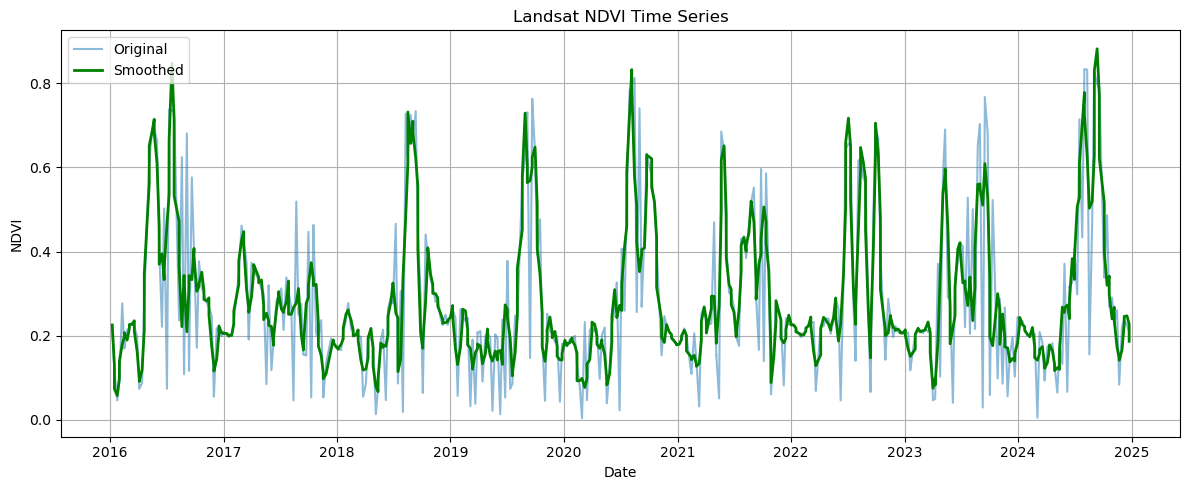

In [52]:
plt.figure(figsize=(12, 5))

# Plot original i35 values
plt.plot(df['date'], df['NDVI'], label='Original', linestyle='-', alpha=0.5)

# Plot smoothed i35 values
plt.plot(df['date'], df['NDVI_smooth'], label='Smoothed', color='green', linewidth=2)

plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('Landsat NDVI Time Series')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('ls_NDVI_time_series.png', dpi=300)
plt.show()

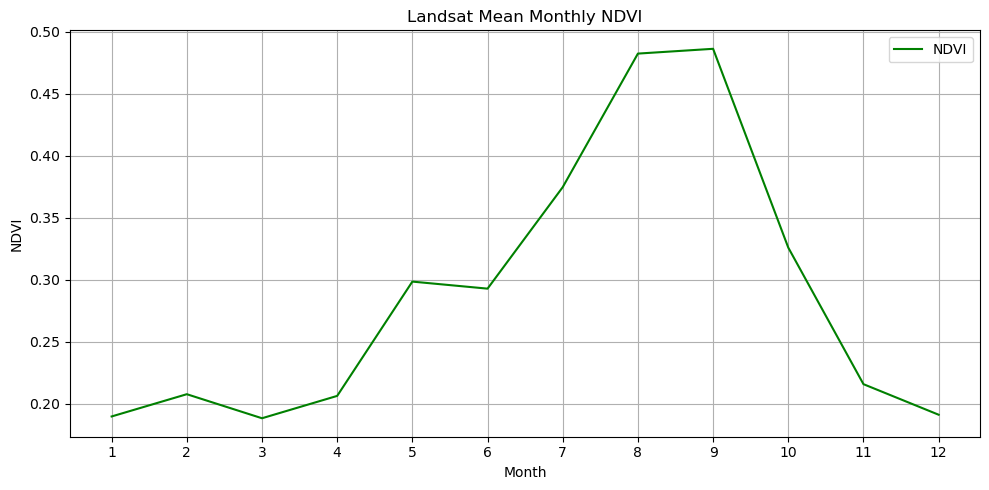

In [53]:
# Add a 'month' column
df['month'] = df['date'].dt.month

# Calculate monthly average i35 across all years
monthly_mean_NDVI = df.groupby('month')['NDVI'].mean().reset_index()

# Apply SG filter
window_length = 7  # should be odd and ≤ number of months (12)
if window_length > len(monthly_mean_NDVI):
    window_length = len(monthly_mean_NDVI) if len(monthly_mean_NDVI) % 2 == 1 else len(monthly_mean_NDVI) - 1
polyorder = 2
monthly_mean_NDVI['NDVI_smooth'] = savgol_filter(monthly_mean_NDVI['NDVI'], window_length, polyorder)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_mean_NDVI['month'], monthly_mean_NDVI['NDVI'], 
         label='NDVI', color = 'green')
#plt.plot(monthly_mean_NDVI['month'], monthly_mean_NDVI['NDVI_smooth'], 
 #        label='Smoothed NDVI (SG Filter)', marker='s', linestyle='--', color='red')

plt.xticks(range(1, 13))
plt.xlabel('Month')
plt.ylabel('NDVI')
plt.title('Landsat Mean Monthly NDVI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('ls_NDVI.png', dpi=300)
plt.show()

# Landsat i35

In [38]:

start_date = '2016-01-01'
end_date = '2024-12-31'

# Load Landsat 8 TOA Reflectance Collection
collection = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')
    .filterBounds(point)
    .filterDate(start_date, end_date)
    .select(['B4', 'B6'])  # Red and SWIR1
)

# Define i35 calculation
def add_i35(image):
    red = image.select('B4')
    swir = image.select('B6')
    i35 = red.add(swir).divide(2).rename('i35')
    return image.addBands(i35)

# Apply function
collection_i35 = collection.map(add_i35).select('i35')

# Extract i35 value and date
def extract_i35(image):
    i35_value = image.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=point,
        scale=30  # Landsat resolution
    ).get('i35')
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'i35': i35_value, 'date': date})

features = collection_i35.map(extract_i35)
feature_list = features.getInfo().get('features', [])

# Convert to DataFrame
data = []
for f in feature_list:
    props = f.get('properties', {})
    if 'date' in props and 'i35' in props and props['i35'] is not None:
        data.append({'date': props['date'], 'i35': props['i35']})

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

# Apply Savitzky-Golay filter
i35_values = df['i35'].values
window_length = 7
if window_length > len(i35_values):
    window_length = len(i35_values) if len(i35_values) % 2 == 1 else len(i35_values) - 1
polyorder = 2
df['i35_smooth'] = savgol_filter(i35_values, window_length, polyorder)

print(df)


          date       i35  i35_smooth
0   2016-01-09  0.323226    0.340682
191 2016-01-16  0.270293    0.294536
390 2016-01-16  0.271820    0.256485
1   2016-01-25  0.407607    0.226529
192 2016-02-01  0.073695    0.184513
..         ...       ...         ...
388 2024-12-07  0.209064    0.220360
587 2024-12-07  0.210767    0.206542
190 2024-12-16  0.251981    0.226913
389 2024-12-23  0.351572    0.292084
588 2024-12-23  0.352983    0.402054

[589 rows x 3 columns]


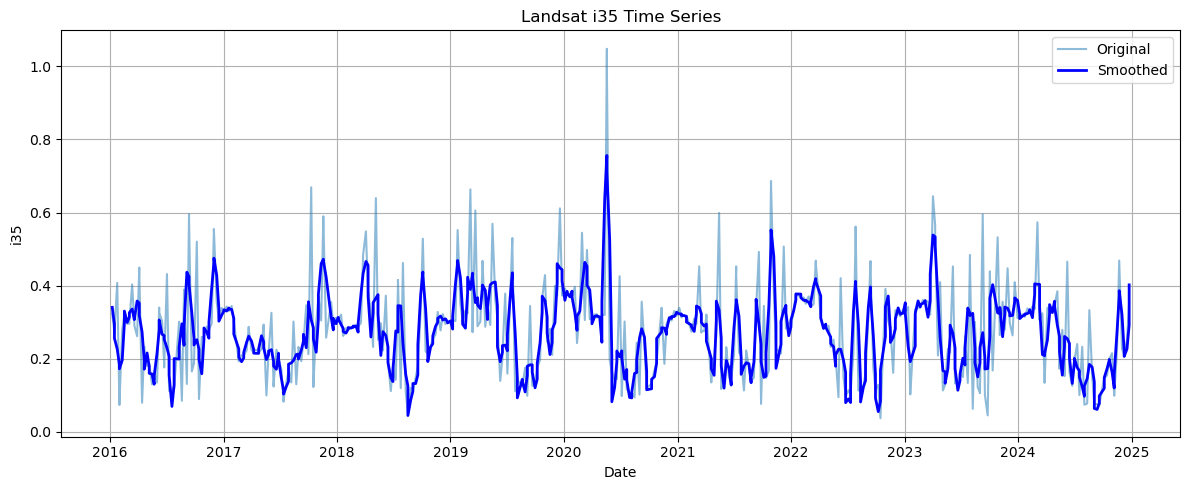

In [39]:
plt.figure(figsize=(12, 5))

# Plot original i35 values
plt.plot(df['date'], df['i35'], label='Original', linestyle='-', alpha=0.5)

# Plot smoothed i35 values
plt.plot(df['date'], df['i35_smooth'], label='Smoothed', color='blue', linewidth=2)

plt.xlabel('Date')
plt.ylabel('i35')
plt.title('Landsat i35 Time Series')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('ls_i35_time_series.png', dpi=300)
plt.show()

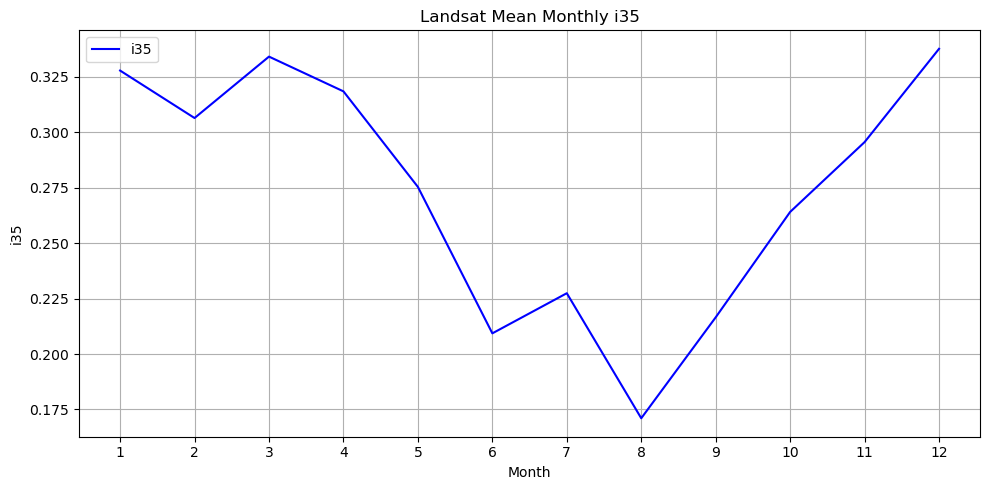

In [40]:
# Add a 'month' column
df['month'] = df['date'].dt.month

# Calculate monthly average i35 across all years
monthly_mean_i35 = df.groupby('month')['i35'].mean().reset_index()

# Apply SG filter
window_length = 7  # should be odd and ≤ number of months (12)
if window_length > len(monthly_mean_i35):
    window_length = len(monthly_mean_i35) if len(monthly_mean_i35) % 2 == 1 else len(monthly_mean_i35) - 1
polyorder = 2
monthly_mean_i35['i35_smooth'] = savgol_filter(monthly_mean_i35['i35'], window_length, polyorder)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_mean_i35['month'], monthly_mean_i35['i35'], 
         label='i35', color = 'blue')
#plt.plot(monthly_mean_i35['month'], monthly_mean_i35['i35_smooth'], 
 #        label='Smoothed i35 (SG Filter)', marker='s', linestyle='--', color='red')

plt.xticks(range(1, 13))
plt.xlabel('Month')
plt.ylabel('i35')
plt.title('Landsat Mean Monthly i35')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('ls_i35.png', dpi=300)
plt.show()

# sentinel 2 NDVI (red-RE)

In [57]:
# Date range 
start_date = '2016-01-01'
end_date = '2024-12-31'

# Load Sentinel-2 Harmonized collection
collection = (
    ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
    .filterBounds(point)
    .filterDate(start_date, end_date)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))  # Cloud filter
    .select(['B4', 'B5', 'B8'])  # Red, RedEdge, NIR
)

# Compute Red & RedEdge NDVI
def add_ndvi_rededge(image):
    red = image.select('B4').multiply(0.0001)
    rededge = image.select('B5').multiply(0.0001)
    nir = image.select('B8').multiply(0.0001)
    a = 0.4
    weighted_red = red.multiply(a).add(rededge.multiply(1 - a))
    ndvi_rededge = nir.subtract(weighted_red).divide(nir.add(weighted_red)).rename('NDVI_redRE')
    return image.addBands(ndvi_rededge)

collection_ndvi = collection.map(add_ndvi_rededge).select('NDVI_redRE')

# Extract NDVI and date
def extract_ndvi(image):
    ndvi_value = image.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=point,
        scale=20  # Sentinel-2 resolution
    ).get('NDVI_redRE')
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'NDVI_redRE': ndvi_value, 'date': date})

features = collection_ndvi.map(extract_ndvi)
feature_list = features.getInfo().get('features', [])

# Build DataFrame
data = []
for f in feature_list:
    props = f.get('properties', {})
    if 'date' in props and 'NDVI_redRE' in props and props['NDVI_redRE'] is not None:
        data.append({'date': props['date'], 'NDVI_redRE': props['NDVI_redRE']})

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

# Smooth NDVI using Savitzky-Golay filter
ndvi_values = df['NDVI_redRE'].values
window_length = 7
if window_length > len(ndvi_values):
    window_length = len(ndvi_values) if len(ndvi_values) % 2 == 1 else len(ndvi_values) - 1
polyorder = 2
df['NDVI_redRE_smooth'] = savgol_filter(ndvi_values, window_length, polyorder)

print(df)


          date  NDVI_redRE  NDVI_redRE_smooth
0   2016-01-03    0.095768           0.086452
1   2016-01-03    0.095768           0.066302
2   2016-01-23    0.003553           0.058607
3   2016-01-23    0.003553           0.063369
4   2016-02-12    0.155955           0.094060
..         ...         ...                ...
625 2024-12-16    0.132016           0.119770
626 2024-12-18    0.121888           0.132105
627 2024-12-21    0.112977           0.131443
628 2024-12-26    0.120464           0.122391
629 2024-12-28    0.115153           0.104948

[630 rows x 3 columns]


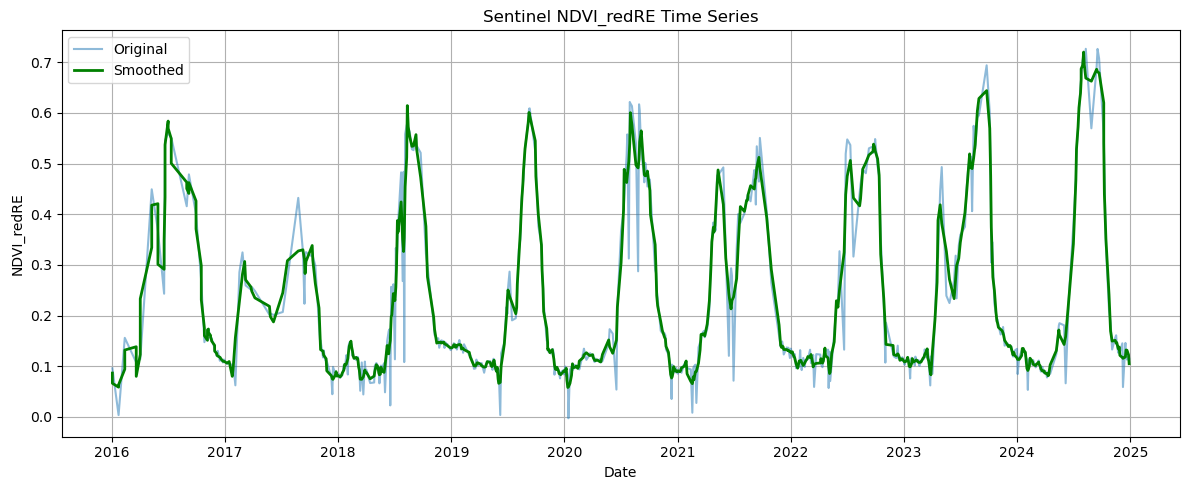

In [58]:
plt.figure(figsize=(12, 5))

# Plot original i35 values
plt.plot(df['date'], df['NDVI_redRE'], label='Original', linestyle='-', alpha=0.5)

# Plot smoothed i35 values
plt.plot(df['date'], df['NDVI_redRE_smooth'], label='Smoothed', color='green', linewidth=2)

plt.xlabel('Date')
plt.ylabel('NDVI_redRE')
plt.title('Sentinel NDVI_redRE Time Series')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('s2_NDVI_redRE_time_series.png', dpi=300)
plt.show()

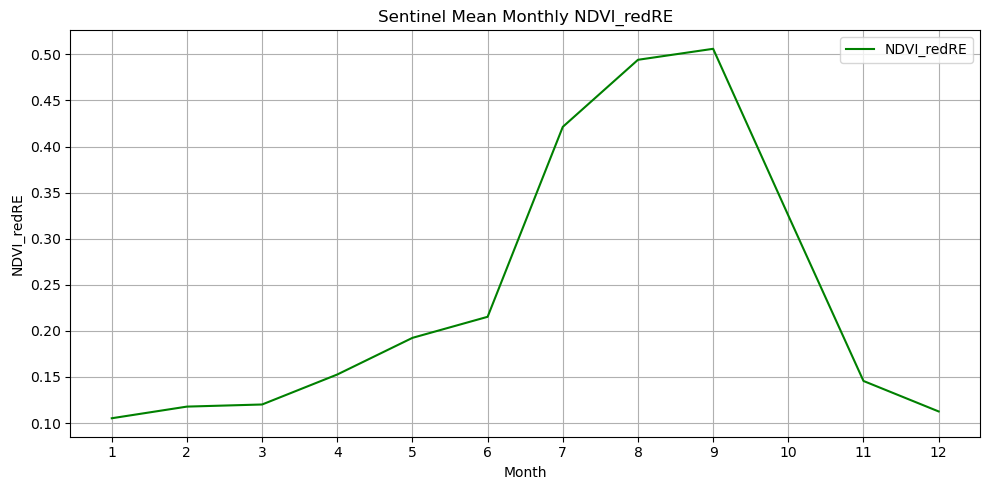

In [59]:
# Add a 'month' column
df['month'] = df['date'].dt.month

# Calculate monthly average i35 across all years
monthly_mean_NDVI_redRE = df.groupby('month')['NDVI_redRE'].mean().reset_index()

# Apply SG filter
window_length = 7  # should be odd and ≤ number of months (12)
if window_length > len(monthly_mean_NDVI_redRE):
    window_length = len(monthly_mean_NDVI_redRE) if len(monthly_mean_NDVI_redRE) % 2 == 1 else len(monthly_mean_NDVI_redRE) - 1
polyorder = 2
monthly_mean_NDVI_redRE['NDVI_redRE_smooth'] = savgol_filter(monthly_mean_NDVI_redRE['NDVI_redRE'], window_length, polyorder)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_mean_NDVI_redRE['month'], monthly_mean_NDVI_redRE['NDVI_redRE'], 
         label='NDVI_redRE', color = 'green')
#plt.plot(monthly_mean_NDVI['month'], monthly_mean_NDVI['NDVI_redRE_smooth'], 
 #        label='Smoothed NDVI_redRE (SG Filter)', marker='s', linestyle='--', color='red')

plt.xticks(range(1, 13))
plt.xlabel('Month')
plt.ylabel('NDVI_redRE')
plt.title('Sentinel Mean Monthly NDVI_redRE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('s2_NDVI_redRE.png', dpi=300)
plt.show()

# sentinel 2 NDVI

In [47]:

# Date range
start_date = '2016-01-01'
end_date = '2024-12-31'

# Load Sentinel-2 Harmonized collection
collection = (
    ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
    .filterBounds(point)
    .filterDate(start_date, end_date)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))  # Cloud filter
    .select(['B4', 'B8'])  # Red and NIR
)

# Compute NDVI
def add_ndvi(image):
    red = image.select('B4').multiply(0.0001)
    nir = image.select('B8').multiply(0.0001)
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
    return image.addBands(ndvi)

collection_ndvi = collection.map(add_ndvi).select('NDVI')

# Extract NDVI and date
def extract_ndvi(image):
    ndvi_value = image.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=point,
        scale=20  # Sentinel-2 resolution
    ).get('NDVI')
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'NDVI': ndvi_value, 'date': date})

features = collection_ndvi.map(extract_ndvi)
feature_list = features.getInfo().get('features', [])

# Build DataFrame
data = []
for f in feature_list:
    props = f.get('properties', {})
    if 'date' in props and 'NDVI' in props and props['NDVI'] is not None:
        data.append({'date': props['date'], 'NDVI': props['NDVI']})

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

# Smooth NDVI using Savitzky-Golay filter
ndvi_values = df['NDVI'].values
window_length = 7
if window_length > len(ndvi_values):
    window_length = len(ndvi_values) if len(ndvi_values) % 2 == 1 else len(ndvi_values) - 1
polyorder = 2
df['NDVI_smooth'] = savgol_filter(ndvi_values, window_length, polyorder)

print(df)


          date      NDVI  NDVI_smooth
0   2016-01-03  0.109486     0.097163
1   2016-01-03  0.109486     0.078835
2   2016-01-23  0.010037     0.072261
3   2016-01-23  0.010037     0.077440
4   2016-02-12  0.178571     0.109677
..         ...       ...          ...
625 2024-12-16  0.156125     0.135962
626 2024-12-18  0.125900     0.147540
627 2024-12-21  0.130524     0.149654
628 2024-12-26  0.142767     0.145015
629 2024-12-28  0.145938     0.133623

[630 rows x 3 columns]


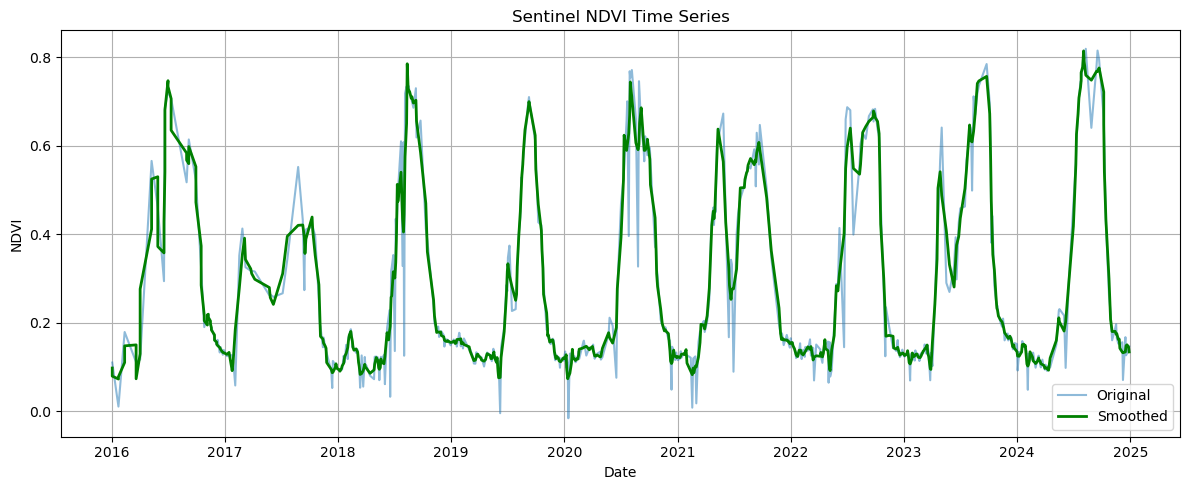

In [48]:
plt.figure(figsize=(12, 5))

# Plot original i35 values
plt.plot(df['date'], df['NDVI'], label='Original', linestyle='-', alpha=0.5)

# Plot smoothed i35 values
plt.plot(df['date'], df['NDVI_smooth'], label='Smoothed', color='green', linewidth=2)

plt.xlabel('Date')
plt.ylabel('NDVI')
plt.title('Sentinel NDVI Time Series')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('s2_NDVI_time_series.png', dpi=300)
plt.show()

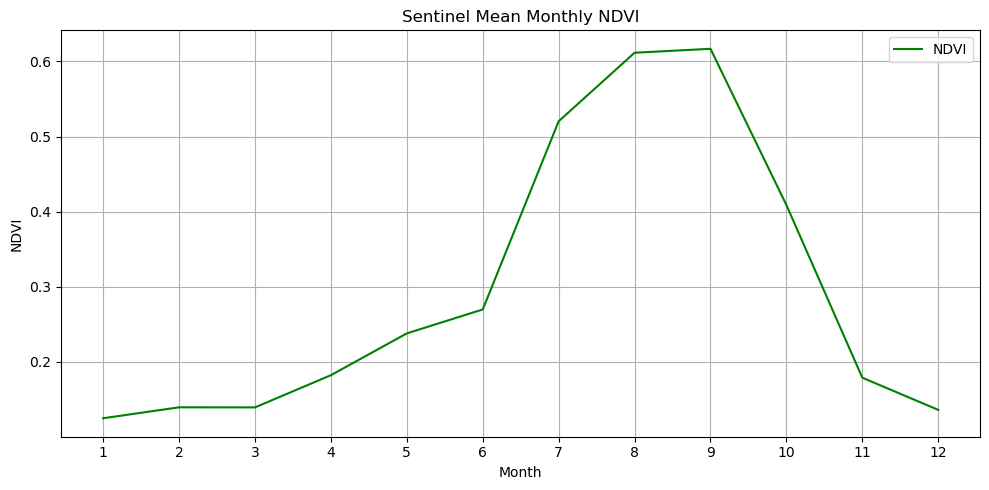

In [50]:
# Add a 'month' column
df['month'] = df['date'].dt.month

# Calculate monthly average i35 across all years
monthly_mean_NDVI = df.groupby('month')['NDVI'].mean().reset_index()

# Apply SG filter
window_length = 7  # should be odd and ≤ number of months (12)
if window_length > len(monthly_mean_NDVI):
    window_length = len(monthly_mean_NDVI) if len(monthly_mean_NDVI) % 2 == 1 else len(monthly_mean_NDVI) - 1
polyorder = 2
monthly_mean_NDVI['NDVI_smooth'] = savgol_filter(monthly_mean_NDVI['NDVI'], window_length, polyorder)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_mean_NDVI['month'], monthly_mean_NDVI['NDVI'], 
         label='NDVI', color = 'green')
#plt.plot(monthly_mean_NDVI['month'], monthly_mean_NDVI['NDVI_smooth'], 
 #        label='Smoothed NDVI (SG Filter)', marker='s', linestyle='--', color='red')

plt.xticks(range(1, 13))
plt.xlabel('Month')
plt.ylabel('NDVI')
plt.title('Sentinel Mean Monthly NDVI')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('s2_NDVI.png', dpi=300)
plt.show()

# sentinel 2 i35

In [42]:
# Date range
start_date = '2016-01-01'
end_date = '2024-12-31'

# Load Sentinel-2 Harmonized collection
collection = (
    ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
    .filterBounds(point)
    .filterDate(start_date, end_date)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))  # Optional cloud filter
    .select(['B4', 'B11'])  # Red and SWIR
)

# Compute i35 index
def add_i35(image):
    red = image.select('B4').multiply(0.0001)
    swir = image.select('B11').multiply(0.0001)
    i35 = red.add(swir).divide(2).rename('i35')
    return image.addBands(i35)

collection_i35 = collection.map(add_i35).select('i35')

# Extract i35 and date
def extract_i35(image):
    i35_value = image.reduceRegion(
        reducer=ee.Reducer.first(),
        geometry=point,
        scale=20  # Sentinel-2 resolution
    ).get('i35')
    date = image.date().format('YYYY-MM-dd')
    return ee.Feature(None, {'i35': i35_value, 'date': date})

features = collection_i35.map(extract_i35)
feature_list = features.getInfo().get('features', [])

# Build DataFrame
data = []
for f in feature_list:
    props = f.get('properties', {})
    if 'date' in props and 'i35' in props and props['i35'] is not None:
        data.append({'date': props['date'], 'i35': props['i35']})

df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

# Smooth i35 using Savitzky-Golay filter
i35_values = df['i35'].values
window_length = 7
if window_length > len(i35_values):
    window_length = len(i35_values) if len(i35_values) % 2 == 1 else len(i35_values) - 1
polyorder = 2
df['i35_smooth'] = savgol_filter(i35_values, window_length, polyorder)

print(df)


          date      i35  i35_smooth
0   2016-01-03  0.32660    0.325793
1   2016-01-03  0.32660    0.446993
2   2016-01-23  0.66860    0.511900
3   2016-01-23  0.66860    0.520514
4   2016-02-12  0.28020    0.443405
..         ...      ...         ...
630 2024-12-16  0.22710    0.263983
631 2024-12-18  0.24990    0.253162
632 2024-12-21  0.34220    0.280032
633 2024-12-26  0.35555    0.336950
634 2024-12-28  0.38925    0.423915

[635 rows x 3 columns]


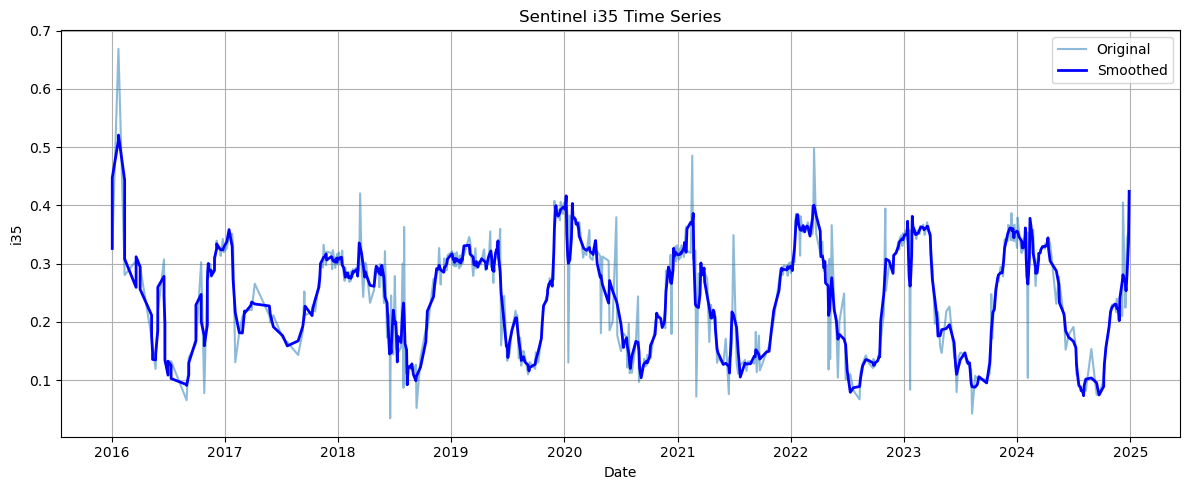

In [43]:
plt.figure(figsize=(12, 5))

# Plot original i35 values
plt.plot(df['date'], df['i35'], label='Original', linestyle='-', alpha=0.5)

# Plot smoothed i35 values
plt.plot(df['date'], df['i35_smooth'], label='Smoothed', color='blue', linewidth=2)

plt.xlabel('Date')
plt.ylabel('i35')
plt.title('Sentinel i35 Time Series')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('s2_i35_time_series.png', dpi=300)
plt.show()

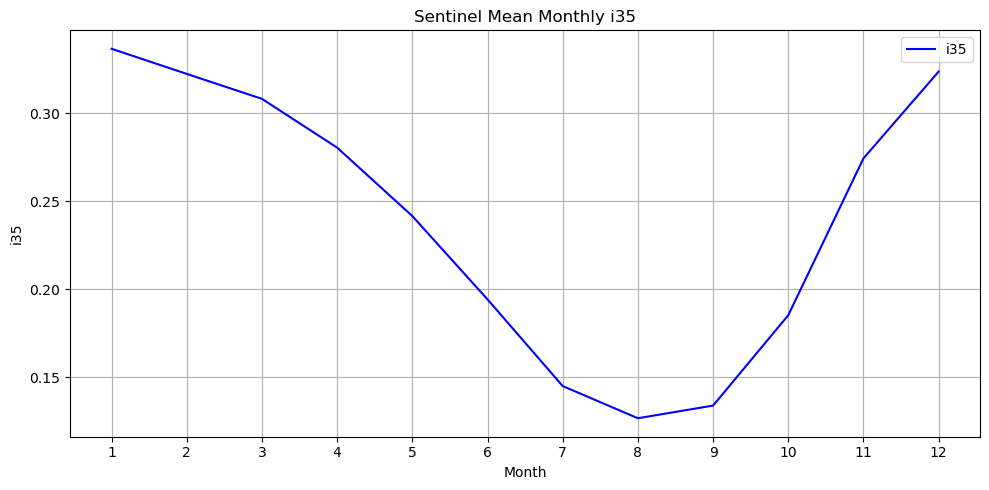

In [46]:
# Add a 'month' column
df['month'] = df['date'].dt.month

# Calculate monthly average i35 across all years
monthly_mean_i35 = df.groupby('month')['i35'].mean().reset_index()

# Apply SG filter
window_length = 7  # should be odd and ≤ number of months (12)
if window_length > len(monthly_mean_i35):
    window_length = len(monthly_mean_i35) if len(monthly_mean_i35) % 2 == 1 else len(monthly_mean_i35) - 1
polyorder = 2
monthly_mean_i35['i35_smooth'] = savgol_filter(monthly_mean_i35['i35'], window_length, polyorder)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(monthly_mean_i35['month'], monthly_mean_i35['i35'], 
         label='i35', color = 'blue')
#plt.plot(monthly_mean_i35['month'], monthly_mean_i35['i35_smooth'], 
 #        label='Smoothed i35 (SG Filter)', marker='s', linestyle='--', color='red')

plt.xticks(range(1, 13))
plt.xlabel('Month')
plt.ylabel('i35')
plt.title('Sentinel Mean Monthly i35')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('s2_i35.png', dpi=300)
plt.show()